<a href="https://colab.research.google.com/github/aqib1/Python_Algorithms/blob/main/explain_image_classification_using_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a81e860b0c7bf1082476a362424036e07529c47c9473eef72e08a2b70d32b6d2
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [183]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.applications.xception import decode_predictions as xception_decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.resnet50 import decode_predictions as resnet50_decode_predictions
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.vgg19 import decode_predictions as vgg19_decode_predictions
from keras.preprocessing import image


import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries, slic
from skimage.io import imread
from google.colab import drive

In [124]:
np.random.seed(10)
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


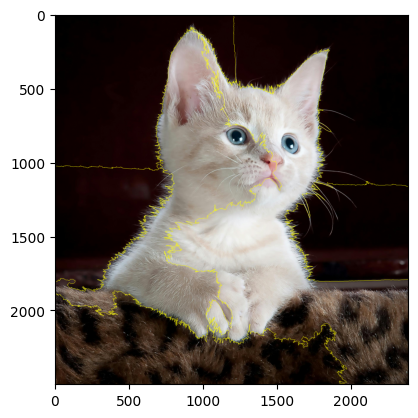

In [125]:
cat_image_path = 'gdrive/MyDrive/Colab Notebooks/images/cat.jpg'
### Experimenting with slic and image segmentation
cat = imread(cat_image_path)
segment = slic(cat, n_segments=10)
outlined = mark_boundaries(cat, segment)
plt.imshow(outlined)
plt.show()

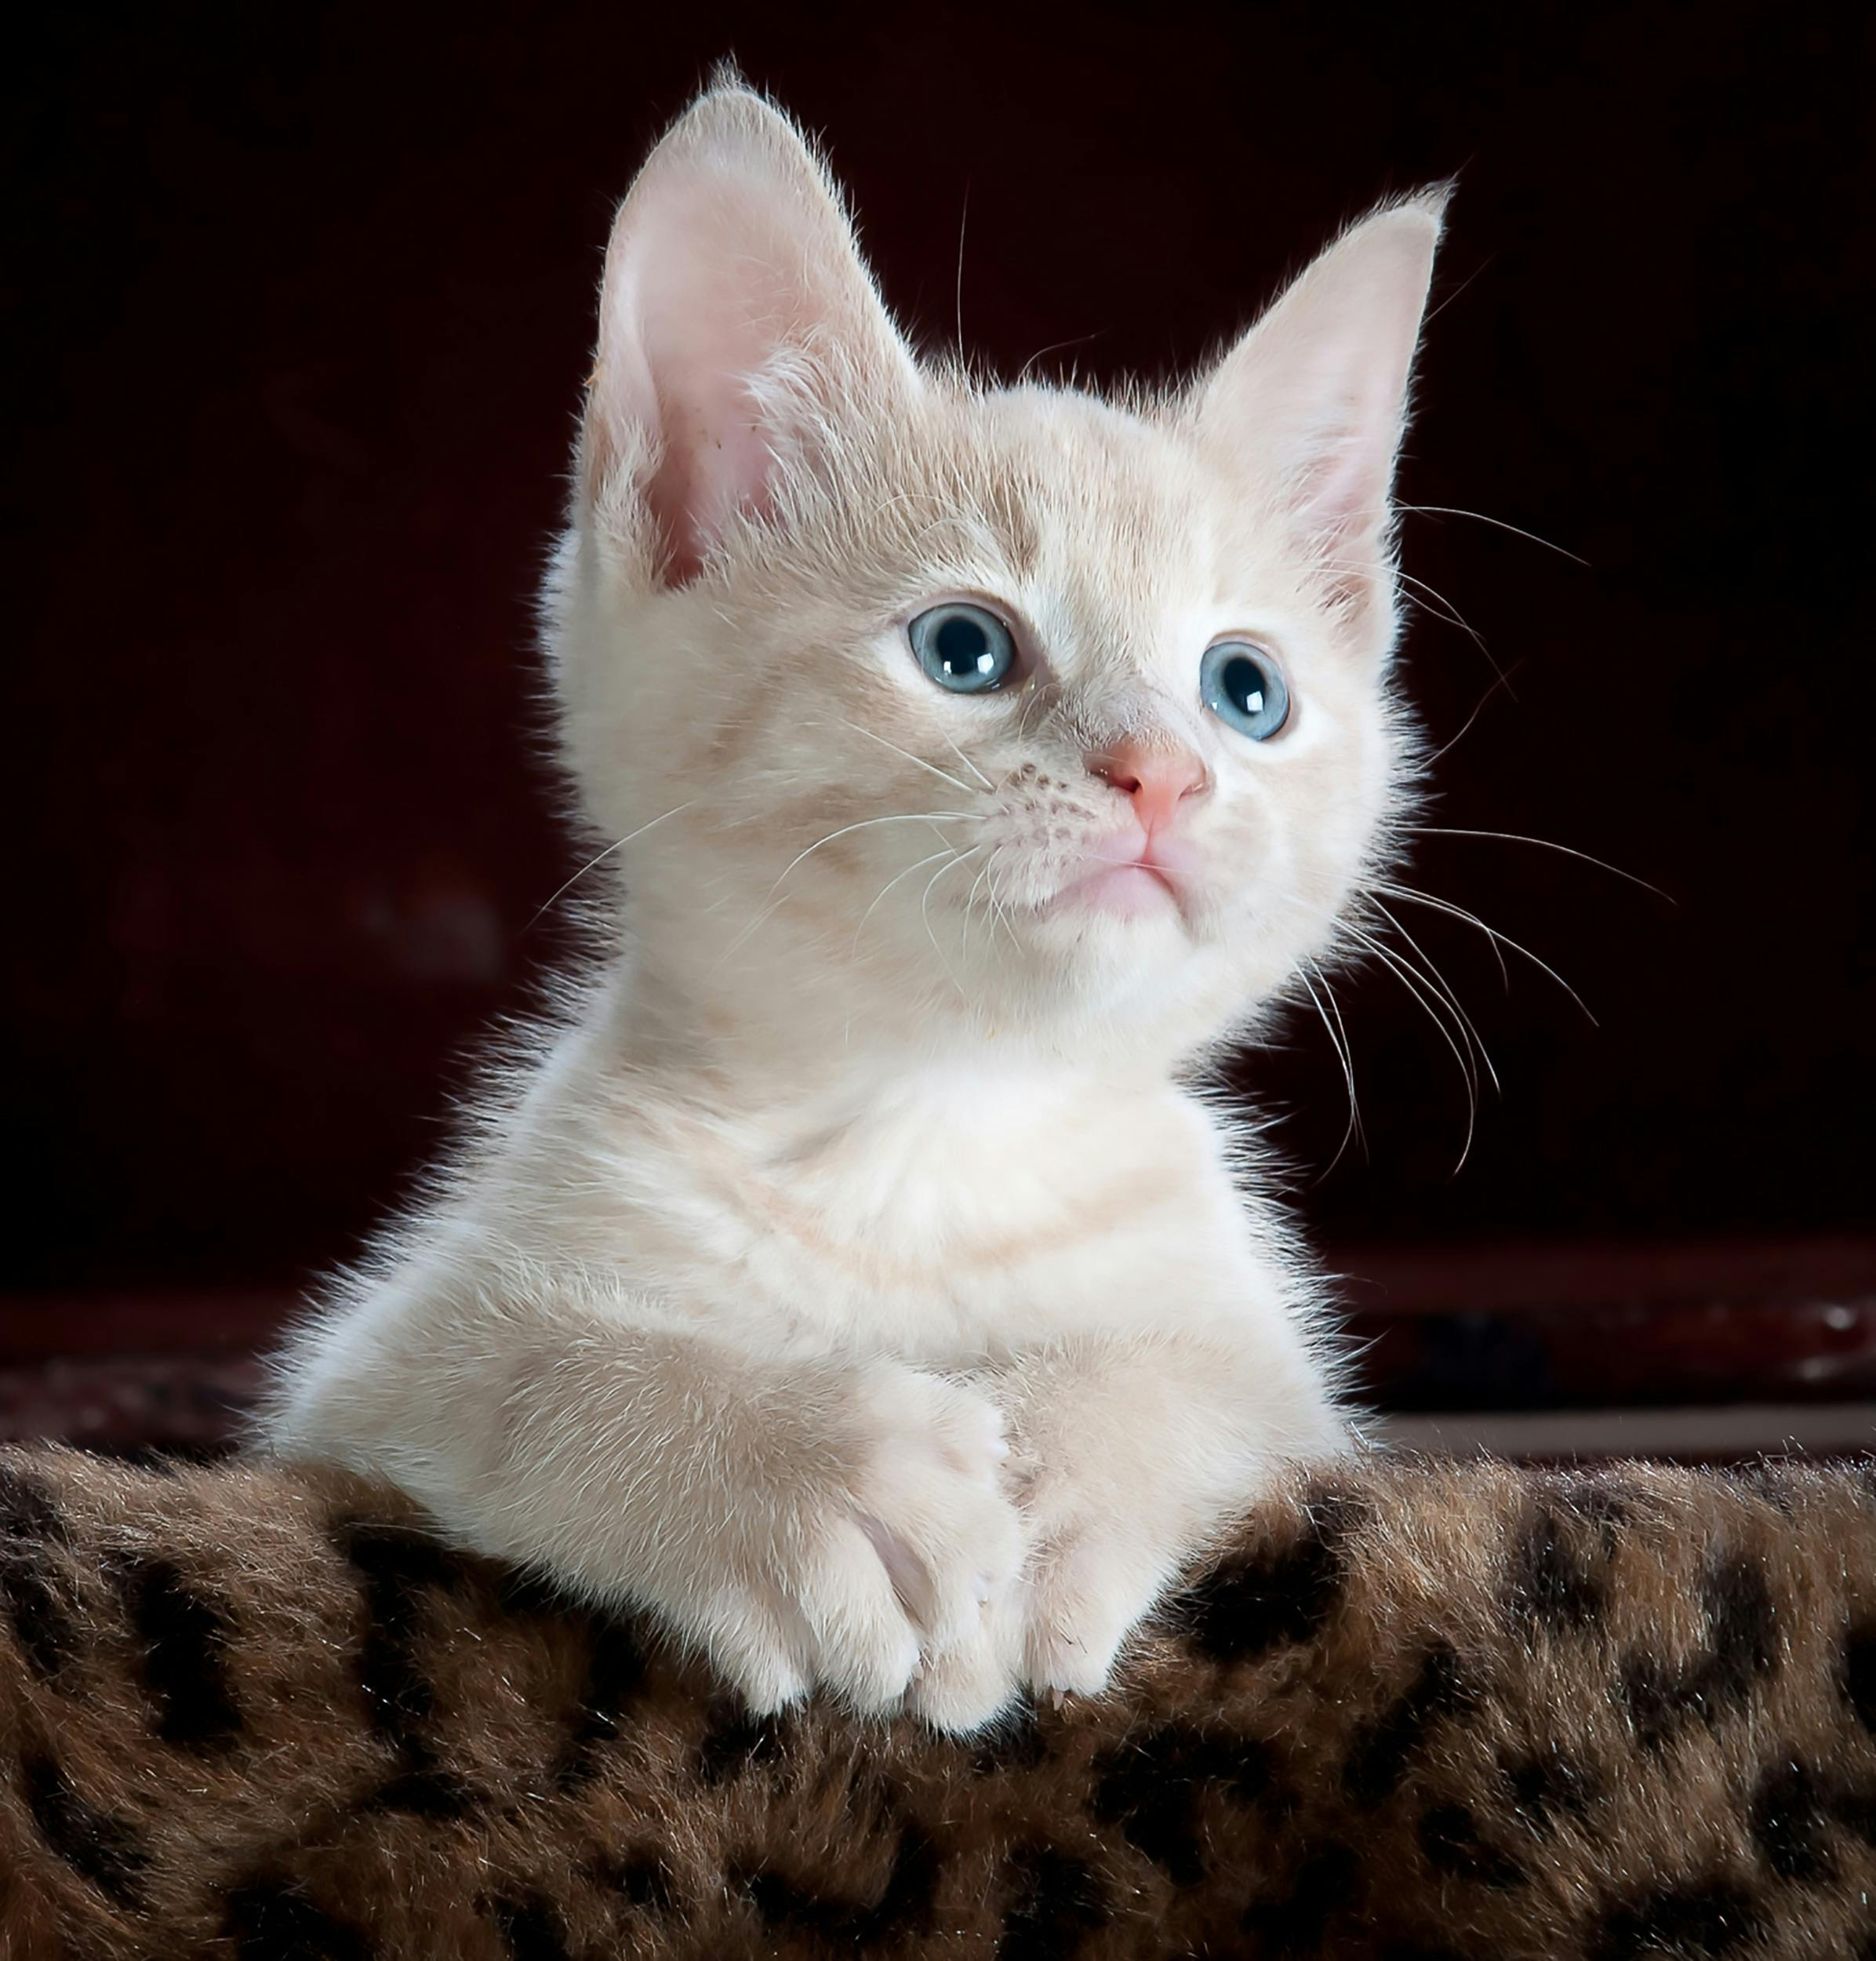

In [126]:
CAT_IMG_SIZE = (299, 299)

display(Image(filename=cat_image_path, width=CAT_IMG_SIZE[0], height=CAT_IMG_SIZE[1]))

In [127]:
def transform_image(image_path, size):
  img = image.load_img(image_path, target_size=size)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0) ## convert image to batch format, as keras/TF model expects batches of image.
  ### Before: 299 x 299 x 3
  ### After: 1 x 299 x 299 x 3
  img = xception_preprocess_input(img) ## convert each pixel to inbetween -1 and 1 or img/255.0
  return img

normalized_img = transform_image(cat_image_path, CAT_IMG_SIZE)
normalized_img

array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.9607843 , -0.99215686, -1.        ],
         [-0.96862745, -1.        , -1.        ],
         [-0.9607843 , -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.96862745, -1.        , -1.        ],
         [-0.96862745, -1.        , -1.        ],
         [-0.9607843 , -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.9607843 , -1.        , -1.        ],
         [-0.9529412 , -0.99215686, -1.        ],
         [-0.92941177, -1.        , -1.        ]],

        ...,

        [[-0.4823529 , -0.6862745 , -0

In [128]:
xception_model = Xception(weights='imagenet')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The predicted class is : [[('n02123394', 'Persian_cat', np.float32(0.23971435))]]
Persian_cat


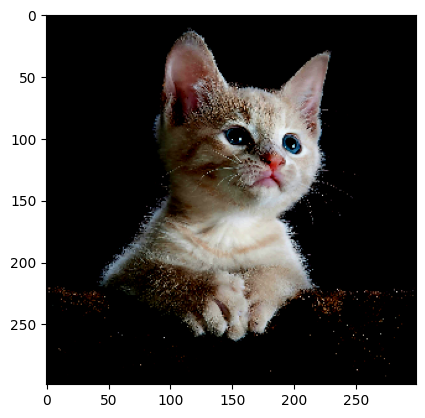

In [129]:
def get_model_predictions(normalized_img, top_n:int):
  model_prediction = xception_model.predict(normalized_img)
  decode_model_prediction = xception_decode_predictions(model_prediction, top=top_n)
  print(f"The predicted class is : {decode_model_prediction}")
  return decode_model_prediction

plt.imshow(normalized_img[0])
top_prediction = get_model_predictions(normalized_img, 1)
print(top_prediction[0][0][1])

In [130]:
top5_prediction = get_model_predictions(normalized_img, 5)

for pre in top5_prediction[0]:
  print(pre[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
The predicted class is : [[('n02123394', 'Persian_cat', np.float32(0.23971435)), ('n02124075', 'Egyptian_cat', np.float32(0.19466701)), ('n02123045', 'tabby', np.float32(0.1255615)), ('n02123159', 'tiger_cat', np.float32(0.01893697)), ('n02123597', 'Siamese_cat', np.float32(0.016769674))]]
Persian_cat
Egyptian_cat
tabby
tiger_cat
Siamese_cat


In [131]:
explainer = lime_image.LimeImageExplainer()
explain_cat = explainer.explain_instance(
    normalized_img[0],
    xception_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

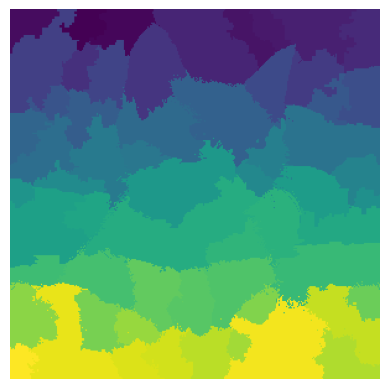

In [132]:
plt.imshow(explain_cat.segments)
plt.axis('off')
plt.show()

In [133]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, num_features = 6, show_positive = True, hide_background = True):
  image, mask = exp.get_image_and_mask(
      exp_class,
      positive_only=show_positive,
      num_features=num_features,
      hide_rest=hide_background,
      min_weight=weight
    )
  plt.imshow(mark_boundaries(image, mask))
  plt.axis('off')
  plt.show()

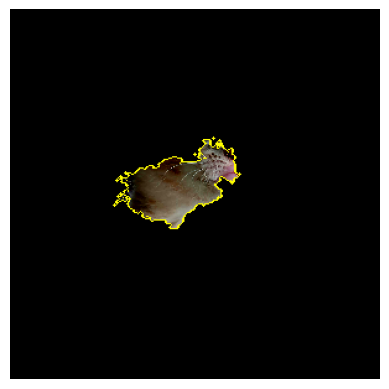

In [134]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=True, hide_background=True, num_features=6, weight=0.1)

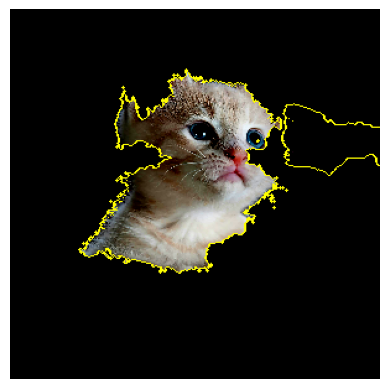

In [135]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=True, hide_background=True, num_features=6, weight=0.01)

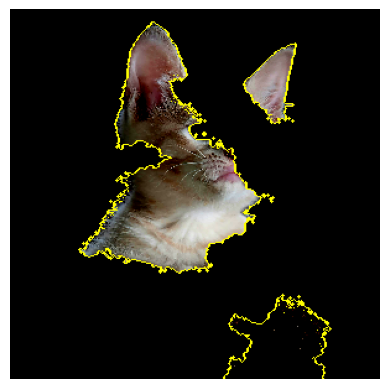

In [136]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[1], show_positive=True, hide_background=True, num_features=6, weight=0.01)

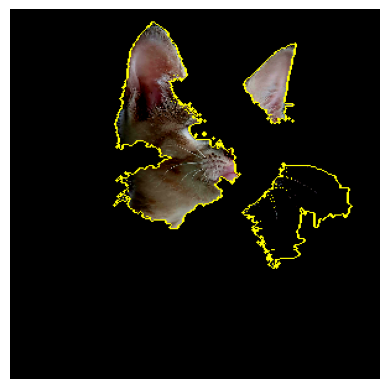

In [137]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[2], show_positive=True, hide_background=True, num_features=6, weight=0.01)

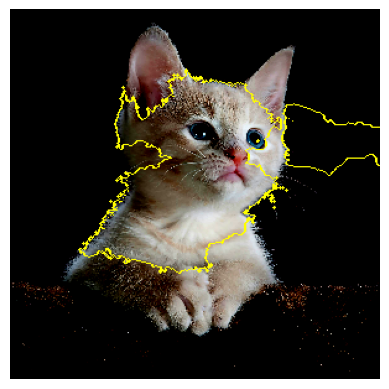

In [138]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=True, hide_background=False, num_features=6, weight=0.01)

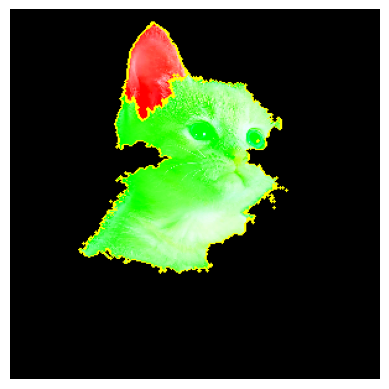

In [139]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=False, hide_background=True, num_features=6, weight=0.01)

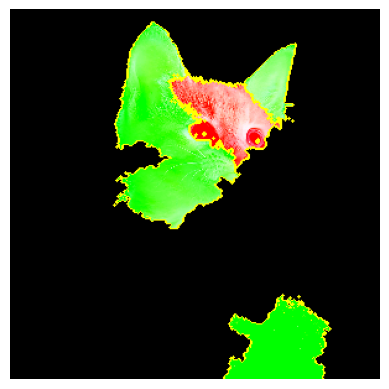

In [140]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[1], show_positive=False, hide_background=True, num_features=6, weight=0.01)

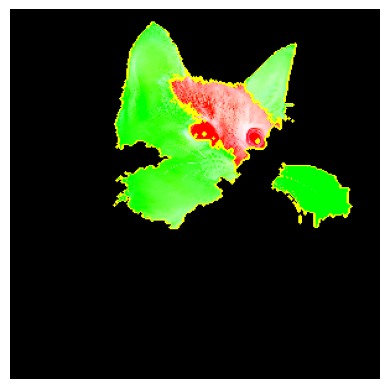

In [141]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[2], show_positive=False, hide_background=True, num_features=6, weight=0.01)

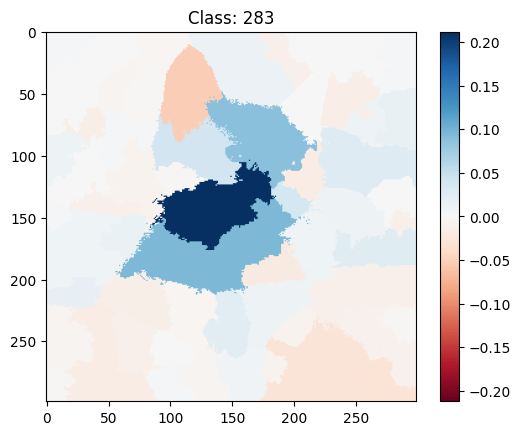

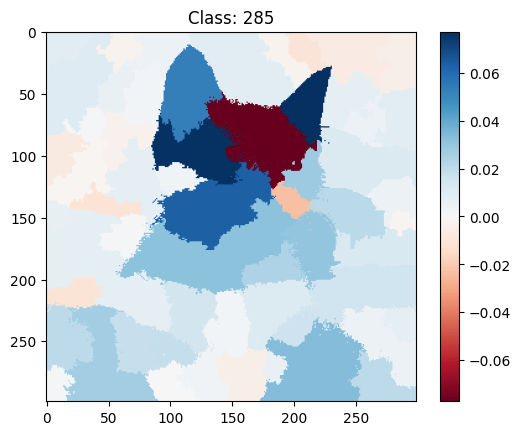

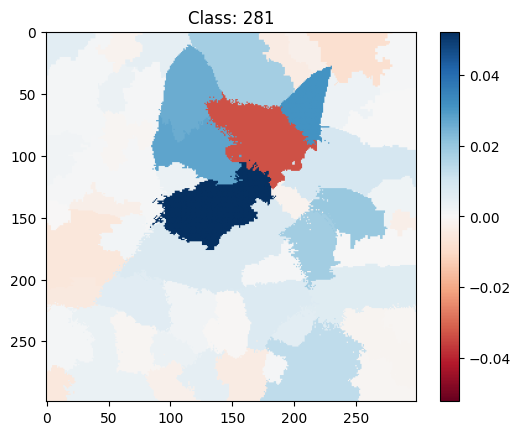

In [142]:
def explanation_heatmap(exp, exp_class):
  dict_heatmap = dict(exp.local_exp[exp_class])
  heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
  plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
  plt.colorbar()
  plt.title(f"Class: {exp_class}")
  plt.show()

for top5 in range(3):
  explanation_heatmap(explain_cat, explain_cat.top_labels[top5])


In [147]:
resNet50 = ResNet50(weights="imagenet")
def transform_image_for_resnet50(image_path, size):
  img = image.load_img(image_path, target_size=size)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0) ## convert image to batch format, as keras/TF model expects batches of image.
  ### Before: 299 x 299 x 3
  ### After: 1 x 299 x 299 x 3
  img = resnet50_preprocess_input(img) ## convert each pixel to inbetween -1 and 1 or img/255.0
  return img

CAT_IMG_SIZE_FOR_RESNET = (224, 224)
normalized_img_resnet50 = transform_image_for_resnet50(cat_image_path, CAT_IMG_SIZE_FOR_RESNET)
normalized_img_resnet50

array([[[[-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         ...,
         [-103.939   , -115.779   , -118.68    ],
         [-103.939   , -115.779   , -118.68    ],
         [-103.939   , -116.779   , -118.68    ]],

        [[-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         ...,
         [-103.939   , -116.779   , -119.68    ],
         [-103.939   , -116.779   , -119.68    ],
         [-103.939   , -116.779   , -114.68    ]],

        [[-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         ...,
         [-103.939   , -116.779   , -119.68    ],
         [-103.939   , -116.779   , -118.68    ],
         [-103.939   , -116.779   , -114.68    ]],

        ...,

        [[ -84.939   ,  -82.779   ,  -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
The predicted class is : [[('n02124075', 'Egyptian_cat', np.float32(0.54931647))]]
Egyptian_cat


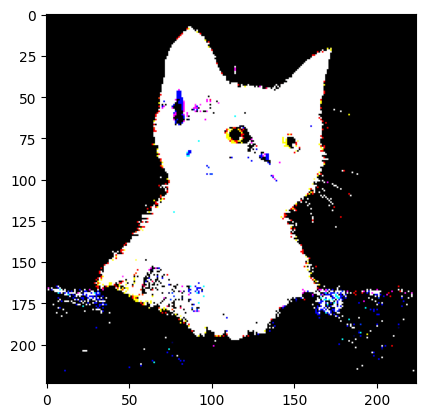

In [149]:
def get_model_predictions_resnet50(normalized_img, top_n:int):
  model_prediction = resNet50.predict(normalized_img)
  decode_model_prediction = resnet50_decode_predictions(model_prediction, top=top_n)
  print(f"The predicted class is : {decode_model_prediction}")
  return decode_model_prediction

plt.imshow(normalized_img_resnet50[0])
top_prediction = get_model_predictions_resnet50(normalized_img_resnet50, 1)
print(top_prediction[0][0][1])

In [150]:
top5_pred_from_resnet50 = get_model_predictions_resnet50(normalized_img_resnet50, 5)[0]

for pred in top5_pred_from_resnet50:
  print(pred[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
The predicted class is : [[('n02124075', 'Egyptian_cat', np.float32(0.54931647)), ('n02123045', 'tabby', np.float32(0.14852613)), ('n02123394', 'Persian_cat', np.float32(0.0833373)), ('n02127052', 'lynx', np.float32(0.05500464)), ('n02123159', 'tiger_cat', np.float32(0.018742366))]]
Egyptian_cat
tabby
Persian_cat
lynx
tiger_cat


In [151]:
explainer_cat = explainer.explain_instance(
    normalized_img_resnet50[0],
    resNet50.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
  )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

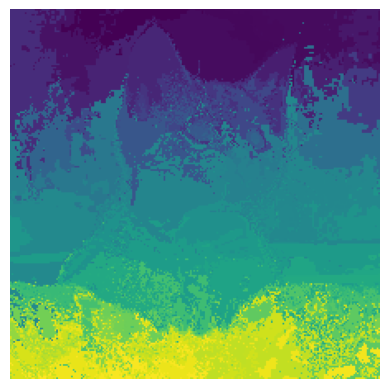

In [153]:
plt.imshow(explainer_cat.segments)
plt.axis('off')
plt.show()

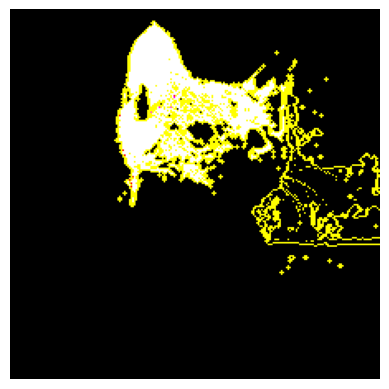

In [162]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive=True, hide_background=True, num_features=6, weight=0.01)

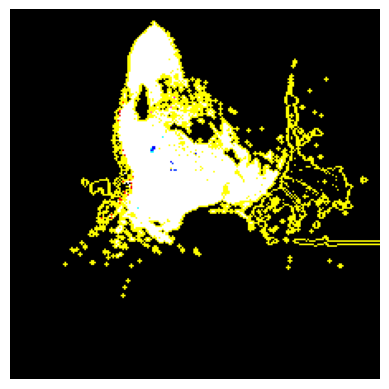

In [170]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[1], show_positive=True, hide_background=True, num_features=6, weight=0.001)

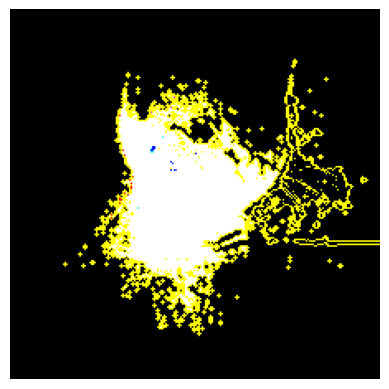

In [171]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[2], show_positive=True, hide_background=True, num_features=6, weight=0.001)

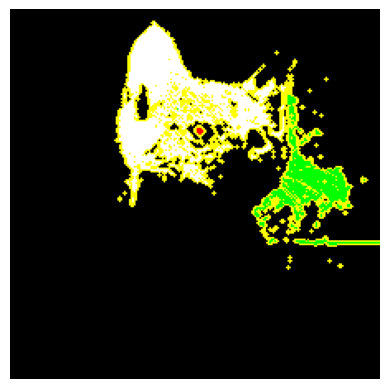

In [172]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive=False, hide_background=True, num_features=6, weight=0.01)

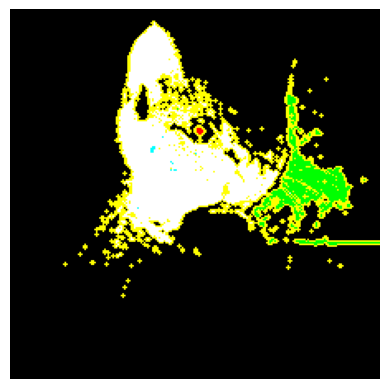

In [174]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[1], show_positive=False, hide_background=True, num_features=6, weight=0.001)

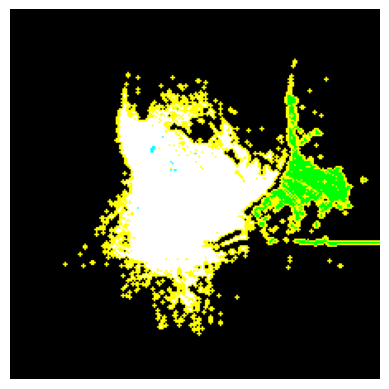

In [175]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[2], show_positive=False, hide_background=True, num_features=6, weight=0.001)

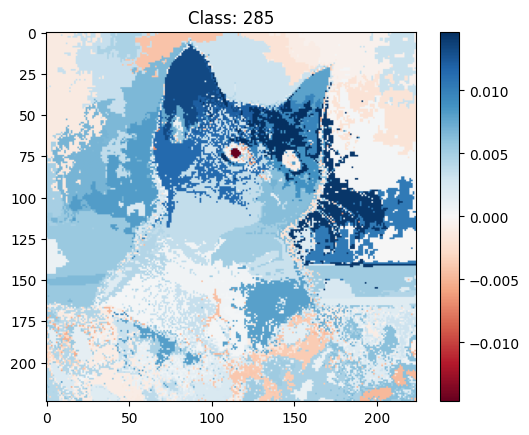

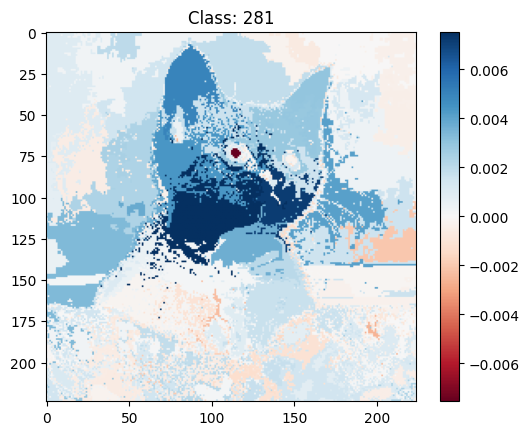

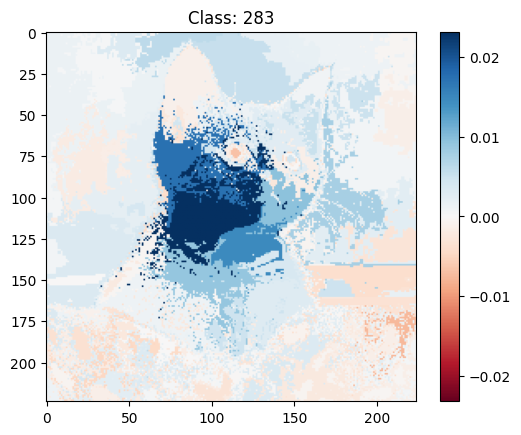

In [182]:
explanation_heatmap(explainer_cat, explainer_cat.top_labels[0])
explanation_heatmap(explainer_cat, explainer_cat.top_labels[1])
explanation_heatmap(explainer_cat, explainer_cat.top_labels[2])

In [184]:
vgg19_model = VGG19(weights='imagenet')

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [189]:
def transform_image_for_vgg19(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = vgg19_preprocess_input(img)

    return img

CAT_IMG_SIZE_VGG19 = (224, 224)
normalized_img_vg99 = transform_image_for_vgg19(cat_image_path, CAT_IMG_SIZE_VGG19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
The predicted class is : [[('n02124075', 'Egyptian_cat', np.float32(0.44007415))]]
Egyptian_cat


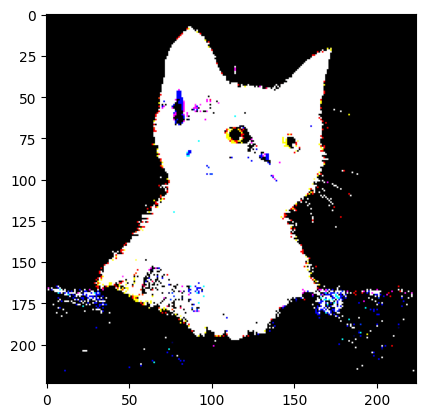

In [190]:
def get_model_predictions_vgg19(data, top_n: int):
    model_prediction = vgg19_model.predict(data)
    decode_predictions_val = vgg19_decode_predictions(model_prediction, top=top_n)
    print(f"The predicted class is : {decode_predictions_val}")
    return decode_predictions_val

plt.imshow(normalized_img_vg99[0])
top_prediction = get_model_predictions_vgg19(normalized_img_vg99, 1)
print(top_prediction[0][0][1])


In [191]:
explainer_cat = explainer.explain_instance(
    normalized_img_vg99[0],
    vgg19_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
  )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

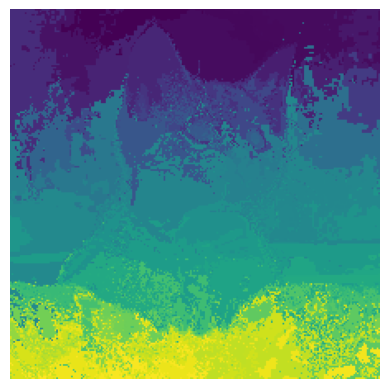

In [192]:
plt.imshow(explainer_cat.segments)
plt.axis('off')
plt.show()

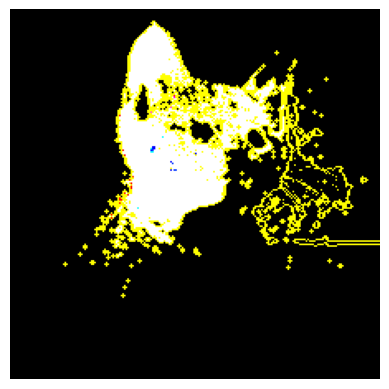

In [195]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive = True, hide_background = True, weight=0.001)

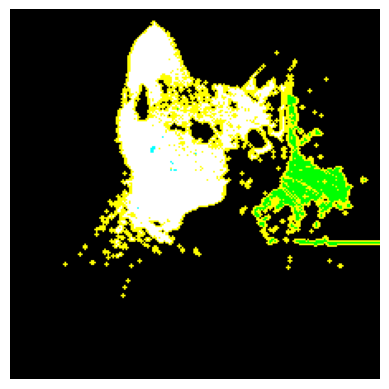

In [196]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive = False, hide_background = True, weight=0.001)

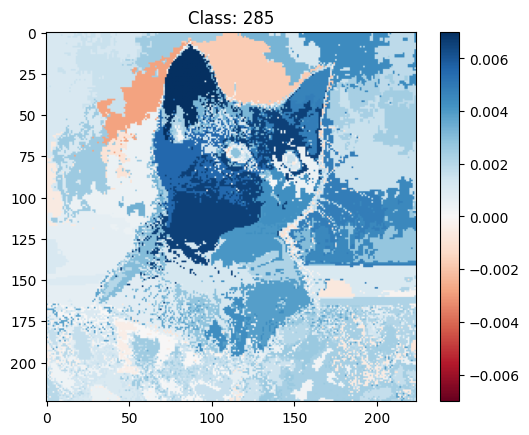

In [197]:
explanation_heatmap(explainer_cat, explainer_cat.top_labels[0])